In [12]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Get the base directory path
from fastf1 import Cache
fastf1.Cache.enable_cache('../data')  # Cache in /data

In [13]:
# 1. Load the 2025 Silverstone FP2 session
session = fastf1.get_session(2025, 'British Grand Prix', 'FP2')
session.load(laps=True, telemetry=True, weather=False)

laps = session.laps
laps

core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:20:58.104000,VER,1,NaT,1.0,1.0,0 days 00:18:56.670000,NaT,NaT,0 days 00:00:54.466000,...,True,Red Bull Racing,0 days 00:18:56.670000,2025-07-04 15:03:56.673,1,NaN,False,,False,False
1,0 days 00:22:25.443000,VER,1,0 days 00:01:27.339000,2.0,1.0,NaT,NaT,0 days 00:00:28.166000,0 days 00:00:35.071000,...,True,Red Bull Racing,0 days 00:20:58.104000,2025-07-04 15:05:58.107,1,NaN,False,,False,True
2,0 days 00:25:13.178000,VER,1,NaT,3.0,1.0,NaT,0 days 00:25:07.144000,0 days 00:00:56.343000,0 days 00:01:10.483000,...,True,Red Bull Racing,0 days 00:22:25.443000,2025-07-04 15:07:25.446,1,NaN,False,,False,False
3,0 days 00:27:56.879000,VER,1,NaT,4.0,2.0,0 days 00:25:41.609000,NaT,0 days 00:01:10.238000,0 days 00:01:03.366000,...,False,Red Bull Racing,0 days 00:25:13.178000,2025-07-04 15:10:13.181,1,NaN,False,,False,False
4,0 days 00:29:24.263000,VER,1,0 days 00:01:27.384000,5.0,2.0,NaT,NaT,0 days 00:00:28.258000,0 days 00:00:34.990000,...,False,Red Bull Racing,0 days 00:27:56.879000,2025-07-04 15:12:56.882,1,NaN,False,,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0 days 01:12:14.053000,BEA,87,0 days 00:01:33.599000,23.0,6.0,NaT,NaT,0 days 00:00:30.216000,0 days 00:00:37.672000,...,False,Haas F1 Team,0 days 01:10:40.454000,2025-07-04 15:55:40.457,1,NaN,False,,False,True
532,0 days 01:13:47.608000,BEA,87,0 days 00:01:33.555000,24.0,6.0,NaT,NaT,0 days 00:00:30.369000,0 days 00:00:37.563000,...,False,Haas F1 Team,0 days 01:12:14.053000,2025-07-04 15:57:14.056,1,NaN,False,,False,True
533,0 days 01:15:20.302000,BEA,87,0 days 00:01:32.694000,25.0,6.0,NaT,NaT,0 days 00:00:30.050000,0 days 00:00:37.360000,...,False,Haas F1 Team,0 days 01:13:47.608000,2025-07-04 15:58:47.611,1,NaN,False,,False,True
534,0 days 01:17:52.359000,BEA,87,NaT,26.0,6.0,NaT,NaT,0 days 00:00:32.432000,0 days 00:01:14.389000,...,False,Haas F1 Team,0 days 01:15:20.302000,2025-07-04 16:00:20.305,1,NaN,False,,False,False


In [14]:
def is_clean_air_lap(lap, gap_threshold=3.0):
    """
    Determine if a lap is in clean air using DriverAheadTime telemetry data
    
    Args:
        lap: The lap to check
        gap_threshold: Minimum gap in seconds to be considered clean air
    
    Returns:
        bool: True if lap is in clean air
    """
    # Use DriverAheadTime from telemetry - much more accurate than time estimation
    driver_ahead_time = lap.get('DriverAheadTime', None)
    
    # If no data available, assume clean air
    if pd.isna(driver_ahead_time) or driver_ahead_time is None:
        return True
    
    # Convert to seconds if it's a timedelta
    if hasattr(driver_ahead_time, 'total_seconds'):
        gap_seconds = driver_ahead_time.total_seconds()
    else:
        gap_seconds = float(driver_ahead_time)
    
    return gap_seconds >= gap_threshold

In [18]:
def extract_race_pace_laps(session_laps, min_stint_length=5):
    """
    Extract race pace representative laps from FP2
    
    Args:
        session_laps: All laps from the session
        min_stint_length: Minimum number of laps in a stint to be considered
    
    Returns:
        DataFrame: Filtered laps suitable for race pace analysis
    """
    race_pace_laps = []
    
    for driver in session_laps['Driver'].unique():
        driver_laps = session_laps[session_laps['Driver'] == driver].copy()
        driver_laps = driver_laps.sort_values('LapStartTime')
        
        # Remove outliers (laps that are too slow or too fast)
        if len(driver_laps) > 0:
            lap_times = driver_laps['LapTime'].dt.total_seconds()
            q1 = np.percentile(lap_times, 25)
            q3 = np.percentile(lap_times, 75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            driver_laps = driver_laps[
                (lap_times >= lower_bound) & 
                (lap_times <= upper_bound)
            ].copy()  # Add .copy() to avoid warnings
        
        # Group consecutive laps into stints
        driver_laps = driver_laps.copy()  # Ensure we have a copy
        driver_laps.loc[:, 'LapNumber'] = range(1, len(driver_laps) + 1)
        driver_laps.loc[:, 'TimeDiff'] = driver_laps['LapStartTime'].diff()
        driver_laps.loc[:, 'NewStint'] = driver_laps['TimeDiff'] > timedelta(minutes=5)
        driver_laps.loc[:, 'StintNumber'] = driver_laps['NewStint'].cumsum()
        
        # Filter stints with minimum length
        stint_lengths = driver_laps.groupby('StintNumber').size()
        valid_stints = stint_lengths[stint_lengths >= min_stint_length].index
        
        driver_race_laps = driver_laps[driver_laps['StintNumber'].isin(valid_stints)].copy()
        
        # Only keep laps from the middle portion of each stint (exclude first 2 and last 2 laps)
        for stint in valid_stints:
            stint_laps = driver_race_laps[driver_race_laps['StintNumber'] == stint].copy()
            if len(stint_laps) > 4:  # Need at least 5 laps to exclude first and last 2
                stint_laps = stint_laps.iloc[2:-2].copy()  # Remove first 2 and last 2 laps
                race_pace_laps.append(stint_laps)
    
    if race_pace_laps:
        return pd.concat(race_pace_laps, ignore_index=True)
    else:
        return pd.DataFrame()

In [19]:
# Get all laps and filter for valid lap times
print("\nProcessing lap data...")
laps = session.laps
valid_laps = laps[
    (laps['LapTime'].notna()) & 
    (laps['IsAccurate'] == True) &
    (~laps['TrackStatus'].isin(['4', '5', '6', '7']))  # Exclude SC, VSC, Red flag conditions
].copy()

print(f"Total laps: {len(laps)}")
print(f"Valid laps: {len(valid_laps)}")


Processing lap data...
Total laps: 536
Valid laps: 314


In [20]:
# Extract race pace laps
race_pace_laps = extract_race_pace_laps(valid_laps)
print(f"Race pace candidate laps: {len(race_pace_laps)}")

race_pace_laps

Race pace candidate laps: 96


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,TimeDiff,NewStint,StintNumber
0,0 days 01:07:36.840000,VER,1,0 days 00:01:32.161000,7.0,5.0,NaT,NaT,0 days 00:00:29.774000,0 days 00:00:37.193000,...,2025-07-04 15:51:04.682,1,NaN,False,,False,True,0 days 00:01:32.016000,False,4
1,0 days 01:09:09.346000,VER,1,0 days 00:01:32.506000,8.0,5.0,NaT,NaT,0 days 00:00:30.039000,0 days 00:00:37.069000,...,2025-07-04 15:52:36.843,1,NaN,False,,False,True,0 days 00:01:32.161000,False,4
2,0 days 01:10:47.979000,VER,1,0 days 00:01:38.633000,9.0,5.0,NaT,NaT,0 days 00:00:30.055000,0 days 00:00:37.106000,...,2025-07-04 15:54:09.349,1,NaN,False,,False,True,0 days 00:01:32.506000,False,4
3,0 days 01:12:19.924000,VER,1,0 days 00:01:31.945000,10.0,5.0,NaT,NaT,0 days 00:00:29.847000,0 days 00:00:36.912000,...,2025-07-04 15:55:47.982,1,NaN,False,,False,True,0 days 00:01:38.633000,False,4
4,0 days 01:07:52.881000,NOR,4,0 days 00:01:32.213000,11.0,4.0,NaT,NaT,0 days 00:00:29.925000,0 days 00:00:37.113000,...,2025-07-04 15:51:20.671,1,NaN,False,,False,True,0 days 00:01:32.368000,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0 days 01:11:14.933000,PIA,81,0 days 00:01:32.107000,10.0,6.0,NaT,NaT,0 days 00:00:29.975000,0 days 00:00:37.061000,...,2025-07-04 15:54:42.829,1,NaN,False,,False,True,0 days 00:01:32.317000,False,5
92,0 days 01:12:47.221000,PIA,81,0 days 00:01:32.288000,11.0,6.0,NaT,NaT,0 days 00:00:29.977000,0 days 00:00:37.124000,...,2025-07-04 15:56:14.936,1,NaN,False,,False,True,0 days 00:01:32.107000,False,5
93,0 days 01:09:07.191000,BEA,87,0 days 00:01:33.328000,9.0,6.0,NaT,NaT,0 days 00:00:30.171000,0 days 00:00:37.404000,...,2025-07-04 15:52:33.866,1,NaN,False,,False,True,0 days 00:01:33.058000,False,5
94,0 days 01:10:40.454000,BEA,87,0 days 00:01:33.263000,10.0,6.0,NaT,NaT,0 days 00:00:30.267000,0 days 00:00:37.415000,...,2025-07-04 15:54:07.194,1,NaN,False,,False,True,0 days 00:01:33.328000,False,5


In [21]:
# Filter for clean air laps using telemetry data
print("\nFiltering for clean air laps using DriverAheadTime telemetry...")
clean_air_laps = []

for idx, lap in race_pace_laps.iterrows():
    if is_clean_air_lap(lap, gap_threshold=3.0):
        clean_air_laps.append(lap)

if clean_air_laps:
    clean_air_df = pd.DataFrame(clean_air_laps)
    print(f"Clean air race pace laps: {len(clean_air_df)}")
    
    # Display some gap statistics
    gap_data = []
    for _, lap in clean_air_df.iterrows():
        gap = lap.get('DriverAheadTime', None)
        if gap is not None and not pd.isna(gap):
            if hasattr(gap, 'total_seconds'):
                gap_data.append(gap.total_seconds())
            else:
                gap_data.append(float(gap))
    
    if gap_data:
        print(f"Average gap to car ahead: {np.mean(gap_data):.2f} seconds")
        print(f"Median gap to car ahead: {np.median(gap_data):.2f} seconds")
        print(f"Min gap to car ahead: {np.min(gap_data):.2f} seconds")
else:
    clean_air_df = pd.DataFrame()
    print("No clean air laps found")


Filtering for clean air laps using DriverAheadTime telemetry...
Clean air race pace laps: 96



CLEAN AIR RACE PACE ANALYSIS

Race Pace Summary (lap times in seconds):
        Laps    Mean  Median     Std    Best    Worst
Driver                                               
NOR        3  92.291  92.297   0.075  92.213   92.362
PIA        4  92.284  92.302   0.132  92.107   92.425
VER        4  93.811  92.334   3.223  91.945   98.633
HAM        1  92.511  92.511     NaN  92.511   92.511
LEC        7  92.331  92.522   0.362  91.620   92.614
RUS        8  92.909  92.893   0.342  92.471   93.470
ALO        3  93.055  93.070   0.087  92.961   93.134
ANT        5  93.037  93.143   0.224  92.669   93.216
ALB        9  93.280  93.222   0.216  92.937   93.663
BEA        3  93.397  93.328   0.178  93.263   93.599
HUL        8  98.847  93.346  19.579  88.094  146.985
STR        3  93.311  93.347   0.120  93.178   93.409
LAW        9  93.413  93.431   0.312  92.965   93.962
HAD        8  93.379  93.453   0.283  92.998   93.733
SAI        6  93.583  93.508   0.300  93.326   94.089
GAS      

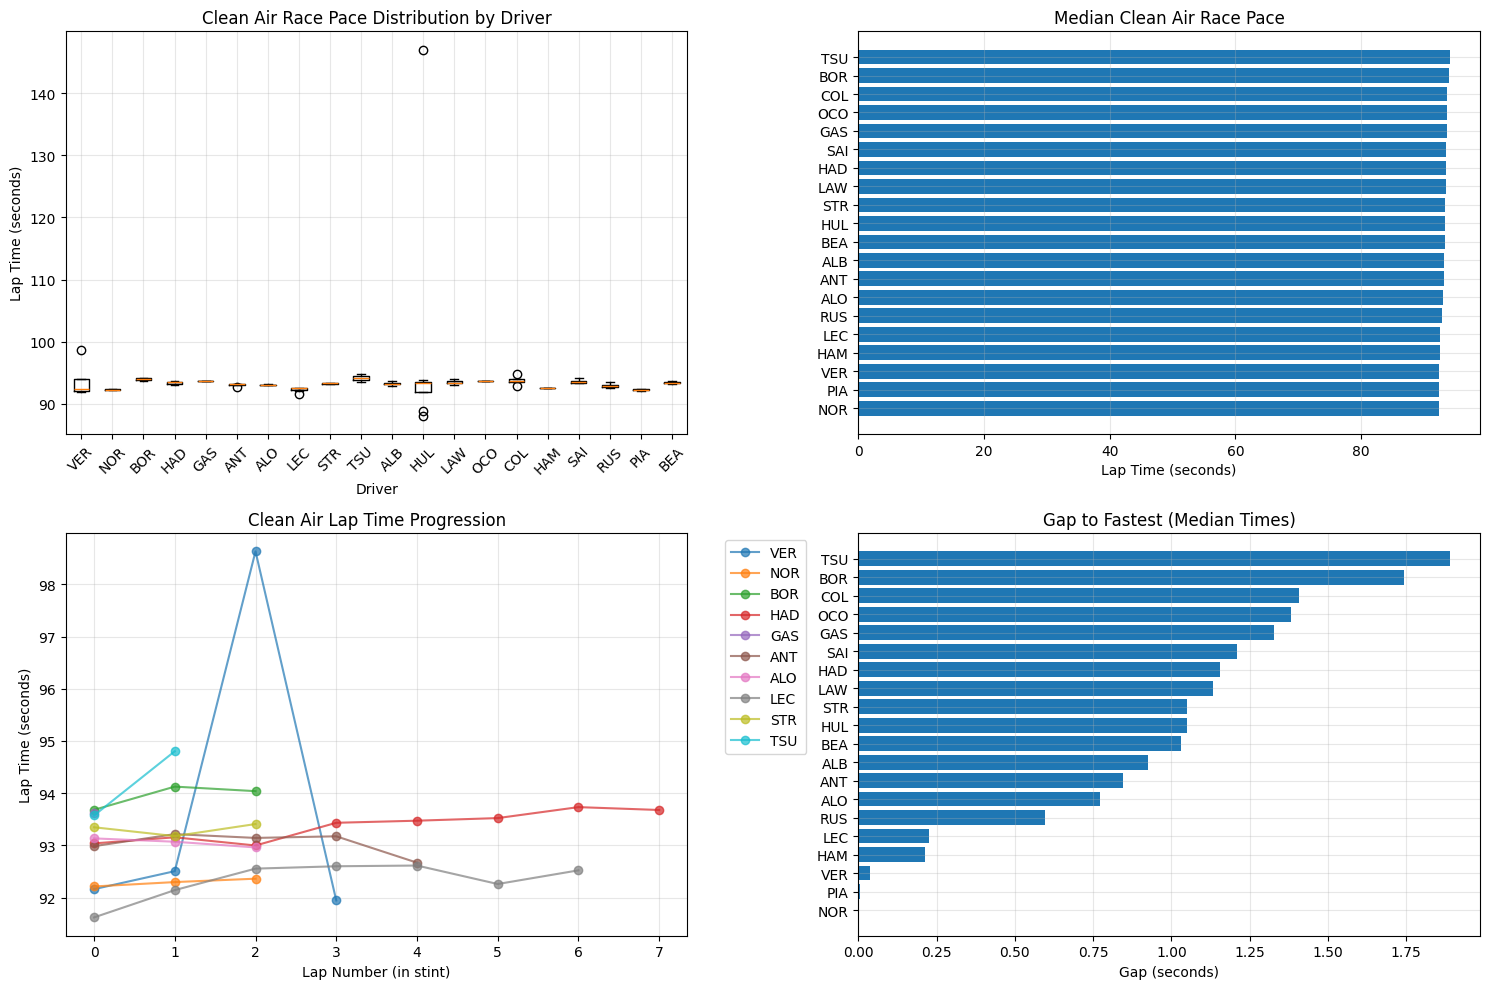


Exporting clean air race pace data...
Data exported to:
- silverstone_2025_clean_air_race_pace.csv
- silverstone_2025_race_pace_summary.csv

Analysis complete!


In [26]:
# Analyze race pace by driver
if not clean_air_df.empty:
    print("\n" + "="*60)
    print("CLEAN AIR RACE PACE ANALYSIS")
    print("="*60)
    
    # Create a copy to avoid warnings and convert lap times to seconds
    analysis_df = clean_air_df.copy()
    analysis_df.loc[:, 'LapTimeSeconds'] = analysis_df['LapTime'].dt.total_seconds()
    
    # Calculate statistics by driver
    pace_analysis = analysis_df.groupby('Driver')['LapTimeSeconds'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(3)
    
    pace_analysis.columns = ['Laps', 'Mean', 'Median', 'Std', 'Best', 'Worst']
    pace_analysis = pace_analysis.sort_values('Median')
    
    print("\nRace Pace Summary (lap times in seconds):")
    print(pace_analysis)
    
    # Convert back to mm:ss.fff format for display
    def seconds_to_laptime(seconds):
        minutes = int(seconds // 60)
        seconds = seconds % 60
        return f"{minutes}:{seconds:06.3f}"
    
    print("\nRace Pace Summary (formatted lap times):")
    pace_display = pace_analysis.copy()
    # Convert numeric columns to object dtype to allow string assignment
    for col in ['Mean', 'Median', 'Best', 'Worst']:
        pace_display[col] = pace_display[col].astype('object')
        pace_display[col] = pace_display[col].apply(seconds_to_laptime)
    
    print(pace_display[['Laps', 'Mean', 'Median', 'Best']])
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Box plot of lap times by driver
    plt.subplot(2, 2, 1)
    drivers_with_data = analysis_df['Driver'].unique()
    lap_times_by_driver = [analysis_df[analysis_df['Driver'] == driver]['LapTimeSeconds'].values 
                          for driver in drivers_with_data]
    
    plt.boxplot(lap_times_by_driver, tick_labels=drivers_with_data)
    plt.title('Clean Air Race Pace Distribution by Driver')
    plt.xlabel('Driver')
    plt.ylabel('Lap Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Median lap time comparison
    plt.subplot(2, 2, 2)
    median_times = pace_analysis['Median'].sort_values()
    plt.barh(range(len(median_times)), median_times.values)
    plt.yticks(range(len(median_times)), median_times.index)
    plt.title('Median Clean Air Race Pace')
    plt.xlabel('Lap Time (seconds)')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Lap time progression
    plt.subplot(2, 2, 3)
    for driver in drivers_with_data[:10]:  # Show top 10 drivers to avoid clutter
        driver_data = analysis_df[analysis_df['Driver'] == driver].sort_values('LapStartTime').copy()
        plt.plot(range(len(driver_data)), driver_data['LapTimeSeconds'], 
                marker='o', label=driver, alpha=0.7)
    
    plt.title('Clean Air Lap Time Progression')
    plt.xlabel('Lap Number (in stint)')
    plt.ylabel('Lap Time (seconds)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Gap to fastest
    plt.subplot(2, 2, 4)
    fastest_median = pace_analysis['Median'].min()
    gaps = pace_analysis['Median'] - fastest_median
    plt.barh(range(len(gaps)), gaps.values)
    plt.yticks(range(len(gaps)), gaps.index)
    plt.title('Gap to Fastest (Median Times)')
    plt.xlabel('Gap (seconds)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Export data
    print(f"\nExporting clean air race pace data...")
    analysis_df.to_csv('../data/silverstone_2025_clean_air_race_pace.csv', index=False)
    pace_analysis.to_csv('../data/silverstone_2025_race_pace_summary.csv')
    
    print("Data exported to:")
    print("- silverstone_2025_clean_air_race_pace.csv")
    print("- silverstone_2025_race_pace_summary.csv")
    
else:
    print("No clean air race pace data available for analysis")

print("\nAnalysis complete!")